In [35]:
# LeastSquares
# Author: Zhang Su (Teaching Assistant)
# Using python3, numpy, matplotlib
# 11 June 2020

# Learning Outcome

By the end of this material, you should be able to:

+ Determine the consistency of a system.
+ Solve least squares problems using normal equations, projection matrix, and QR factors.
+ (Bonus) Utilize the pseudo inverse to solve a least squares problem when $A^TA$ is singular.

Note: 
1. If you occasionally double clicked a textual cell, the display would change to markdown source code. To reverse, simply click anywhere of that markdown cell,  and then click **Run** in the top manu.
2. Sometimes the notebook may not be responding. That is caused by the failure of jupyter kernel. To repair, try clicking **Kernel** in the top manu, then clicking **Reconnect**. 
3. Section Takeaways summarizes useful tips, e.g., holes of Python to avoid, if any.
4. Section Practice reflect the learning outcomes. You are expected to solve them based on your understanding on the lecture notes alone with the coding skills learned from this demo.

# Table of contents <a name="Table_of_Content"></a>
+ 7.1.1. [Consistency in a System of Equations](#CSE) 
+ 7.1.2 [The Least Squares Problem and Best Approx](#TLSPBA) 
+ 7.1.3 [The Normal Equation](#NE) 
    + [Example 1, when $A^TA$ is invertible](#NEI)
    + [Example 2, when $A^TA$ is not invertible](#NENI)
+ 7.1.4 [Projection Matrix and Its Properties](#PMP)
    + [Example 1, when $A^TA$ is invertible](#PMPI)
    + [Example 2, when $A^TA$ is not invertible](#PMPNI)
    + [Properties of Projection Matrix](#PPM)
+ 7.1.5 [Revisiting QR Factorisation and Solving](#QR)
    + [Example 1, when $A^TA$ is invertible](#QRI)
    + [Example 2, when $A^TA$ is not invertible](#QRNI)
+ [Takeaways](#Takeaways)
+ [Practice](#Practice)

Let's import libraries. Today we have several new libraries (The following libraries have already been installed by `conda install matplotlib` when we configure the virtual environment, so don't worry). `mpl_toolkits.mplot3d` provides some basic 3D plotting (scatter, surf, line, mesh) tools. `matplotlib.pyplot` is a collection of command style functions that make matplotlib work like MATLAB. `pyLab` is a procedural interface to the Matplotlib object-oriented plotting library. 

In [36]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pylab import *

### Consistency in a System of Equations<a name="CSE"></a>
[Return to Table of Content](#Table_of_Content)

There are two cases regarding the consistency of a equation system, **consistent** and **inconsistent**.

For a consistent system, it may have unique or infinite solutions.

For an inconsistent system, it has no solution. Nonetheless, we can find an approximation of the solution, which is the best we can do.

Let's first define a helper function to show the system consistency.

In [37]:
def consistency_check(A, b):
# Input: the m-by-n matrix A and n-by-1 vector b
# Output: printing the rank(A), rank(Ab), and column number n
    # Concatenate A and b
    Augmented_Ab = np.c_[A, b]
    
    # Find the rank
    rank_A = la.matrix_rank(A)
    rank_Ab = la.matrix_rank(Augmented_Ab)
    
    # Find the column number
    n = A.shape[1]

    print("Rank(A) =", rank_A)
    print("Rank(A|b) =", rank_Ab)
    print("n =", n)

Examples are given below.

#### A consistent system with unique equation

$$
rank(A)=rank(A|b)=n,
$$
where $n$ equals the number of unknowns, or, the column number of $A$.

In [38]:
A = np.array([[2,4],
             [1,3]])
b = np.array([[6, 4]]).T

consistency_check(A, b)

Rank(A) = 2
Rank(A|b) = 2
n = 2


#### A consistent system with infinite equation

$$
rank(A)=rank(A|b)<n,
$$
where $n$ equals the number of unknowns, or, the column number of $A$.

In [39]:
A = np.array([[2,4],
             [1,2]])
b = np.array([[6, 3]]).T

consistency_check(A, b)

Rank(A) = 1
Rank(A|b) = 1
n = 2


#### An inconsistent system

$$
rank(A)<rank(A|b).
$$


In [40]:
A = np.array([[2,4],
             [1,2]])
b = np.array([[6, 4]]).T

consistency_check(A, b)

Rank(A) = 1
Rank(A|b) = 2
n = 2


### The Least Squares Problem and Best Approx<a name="TLSPBA"></a>
[Return to Table of Content](#Table_of_Content)

The least-squares solution is defined as follows.

![](img/least_square_problem.png)
>Figure 1. The least squares solution $\hat{x}$.

Within the column space of $A$, there are lots of $x$s can be found. But only one of them, denoted by $\hat{x}$, has the smallest distance to $b$. As visualized below.

![](img/least_square_problem_2.png)
>Figure 2. The visualization of the approximation. $A\hat{x}$ is the best approximation, it is actually the projection of $b$ onto $Col A$.

Let us implement the example in our slides. 

Given $A=\begin{pmatrix}
2 & 0\\
-1 & 1\\
0 & 2
\end{pmatrix}$ and $b=\begin{pmatrix}1\\0\\-1\end{pmatrix}$, the goal is to compute and visualize the distance between every possible approximation $Ax$ to the target $b$. The specific idea for the implementation is explained as follows.

First, we will define two variables `x1` and `x2`, which contain the x- and y-coordinate for each  candidate `x`,  in the interval of `[-1, +1]`, with a step size of 0.1. Thus we form a grid with 400 `x`s. Such a grid can be created using `np.meshgrid()`.

After which, we would like to calculate `z = b - Ax`, and visualize `z` as the height of the corresponding `x`. 

You may rotate the figure using your mouse once it is drawn. 

### You may need to re-run the cell below to show the interactive plot currectly.

<IPython.core.display.Javascript object>


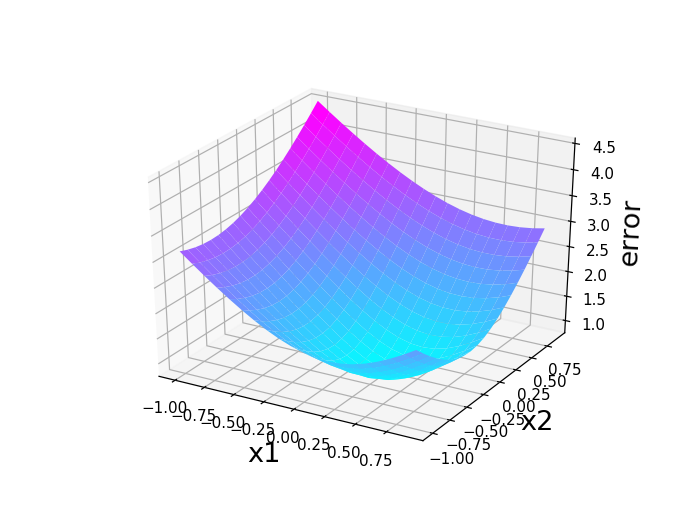

The point with the minimal error is 
 x1=[0.3], x2=[-0.3], error = [0.82462113]


In [41]:
A = np.array([[2,0],
             [-1,1],
             [0,2]], dtype=float)

b = np.array([[1,0,-1]]).T

# This makes the plot interactive, by which we can rotate the plot!
%matplotlib notebook 

# Plot
x1, x2 = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))


m, n = x1.shape
z = np.zeros((m, n))

# Use brute force to calculate the errors for all xs.
for i in range(m):
    for j in range(n):
        z[i, j] = la.norm(b.T - (x1[i, j] * A[:,0] + x2[i, j] * A[:,1]))  

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, z, rstride=1, cstride=1, cmap=cm.cool, antialiased=True)
xlabel('x1', fontsize=18)
ylabel('x2', fontsize=18)
ax.set_zlabel('error', fontsize=18)
plt.show()

min_index= np.where(z == z.min())
result = 'x1={}, x2={}, error = {}'.format(x1[min_index], x2[min_index], z[min_index])
print("The point with the minimal error is \n", result)

### The Normal Equation<a name="NE"></a>
[Return to Table of Content](#Table_of_Content)

The normal equation is written as:
$$
\begin{equation}
A^TAx = A^Tb, \tag{1}
\end{equation}
$$

by which we further have:
$$
\begin{equation}
\hat{x} =(A^TA)^{-1}A^Tb, \tag{2}
\end{equation}
$$

To utilize Eq. (2) to find $\hat{x}$, we have to ensure that the matrix `AtA` is invertible. One way to determine this is to see whether matrix `AtA` is full-rank, another way is to see whether the determinant of `AtA` is non-zero. In the cell below we can see that `A` has two linearly independent columns, and matrix `AtA` is full-rank, and it's determinant is non-zero. It's safe to use the normal equation.

#### Example 1, when $A^TA$ is invertible<a name="NEI"></a>
[Return to Table of Content](#Table_of_Content)

In [42]:
A = np.array([[4,0],
             [0,2],
             [1,1]], dtype=float)

b = np.array([[2,0,11]]).T

AtA = np.dot(A.T, A)
Atb = np.dot(A.T, b)
rank_AtA = la.matrix_rank(AtA)
determinant_AtA = la.det(AtA)

print('The shape of matrix AtA is:\n', AtA.shape)
print('The rank of matrix AtA is:\n', rank_AtA)
print('The determinant of matrix AtA is:\n', determinant_AtA)

# Eq. 2
x_hat = la.inv(AtA).dot(Atb)
error = la.norm(b - A.dot(x_hat))
print("The least squares solution  =\n", x_hat)
print("The least squares error  =\n", error)

The shape of matrix AtA is:
 (2, 2)
The rank of matrix AtA is:
 2
The determinant of matrix AtA is:
 83.99999999999999
The least squares solution  =
 [[1.]
 [2.]]
The least squares error  =
 9.16515138991168


Recall the vanilla inverse `numpy.linalg.inv()` and pseudo inverse `numpy.linalg.pinv()` we met in the lecture notes, let's see if the errors for these two methods are equal. (If you do not know pseudo inverse, don't worry, we will face it in Chapter 8 :) It's good to have some senses for now.)

#### Example 2, when $A^TA$ is not invertible<a name="NENI"></a>
[Return to Table of Content](#Table_of_Content)

In the cell below `A` has linear dependent columns. So that the rank of `AtA` is not full, and the determinant is zero. (Though it is not exactly zero, but we can safely think so.)

In [43]:
A = np.array([[1,1,0,0],
              [1,1,0,0],
              [1,0,1,0],
              [1,0,1,0],
              [1,0,0,1],
              [1,0,0,1]], dtype=float)

b = np.array([[-3,-1,0,2,5,1]]).T

AtA = np.dot(A.T, A)
Atb = np.dot(A.T, b)
rank_AtA = la.matrix_rank(AtA)
determinant_AtA = la.det(AtA)

print('The shape of matrix AtA is:\n', AtA.shape)
print('The rank of matrix AtA is:\n', rank_AtA)
print('The determinant of matrix AtA is:\n', determinant_AtA)

The shape of matrix AtA is:
 (4, 4)
The rank of matrix AtA is:
 3
The determinant of matrix AtA is:
 5.329070518200744e-15


We also investigate the vanilla and pseudo inverse of $A^TA$.  We will see that the vanilla inverse of such a singular matrix is infinite, while the pseudo inverse preserve meaningful values.

**(If you do not know pseudo inverse, don't worry, we will explain it in Chapter 8 :) It's good to have some senses for now.)**

In [44]:
print('The vanilla inverse of matrix AtA is:\n', la.inv(AtA))
print('The pseudo inverse of matrix AtA is:\n', la.pinv(AtA))

The vanilla inverse of matrix AtA is:
 [[ 1.50119988e+15 -1.50119988e+15 -1.50119988e+15 -1.50119988e+15]
 [-1.50119988e+15  1.50119988e+15  1.50119988e+15  1.50119988e+15]
 [-1.50119988e+15  1.50119988e+15  1.50119988e+15  1.50119988e+15]
 [-1.50119988e+15  1.50119988e+15  1.50119988e+15  1.50119988e+15]]
The pseudo inverse of matrix AtA is:
 [[ 0.09375  0.03125  0.03125  0.03125]
 [ 0.03125  0.34375 -0.15625 -0.15625]
 [ 0.03125 -0.15625  0.34375 -0.15625]
 [ 0.03125 -0.15625 -0.15625  0.34375]]


We then compare the following methods:

$$
\begin{align}
\hat{x}&=(A^TA)^{-1}A^Tb \tag{2}\\
\hat{x}&=A^{-1}b \tag{3}\\
\hat{x}&=(A^TA)^{+}A^Tb \tag{4}\\
\hat{x}&=A^{+}b \tag{5}
\end{align}
$$

where the superscript $+$ denotes the pseudo inverse.

Since $A$ is not invertible, we can guess that Eq. (2) and (3) will fail.



In [45]:
# Eq. 2
x_hat_inv_1 = la.inv(AtA).dot(Atb)
error_inv = la.norm(b - A.dot(x_hat_inv_1))

# Eq. 3
# x_hat_inv_2 = np.dot(la.inv(A), b) # This will raise an error because `A` is not square.

# Eq. 4
x_hat_pinv_1 = la.pinv(AtA).dot(Atb)
error_pinv_1 = la.norm(b - A.dot(x_hat_pinv_1))

# Eq. 5
x_hat_pinv_2 = np.dot(la.pinv(A), b)
error_pinv_2 = la.norm(b - A.dot(x_hat_pinv_2))


print("x_hat obtained using vanilla inverse with normal equation =\n", x_hat_inv_1)
print("x_hat obtained using direct vanilla inverse raises an error.")
print("x_hat obtained using pseudo inverse with normal equation =\n", x_hat_pinv_1)
print("x_hat obtained using direct pseudo inverse with normal equation =\n", x_hat_pinv_2)
print("\n")

print("The least squares error using vanilla inverse with normal equation =\n", error_inv)
print("The least squares error using pseudo inverse with normal equation =\n", error_pinv_1)
print("The least squares error using direct pseudo inverse =\n", error_pinv_2)

x_hat obtained using vanilla inverse with normal equation =
 [[ 0.]
 [-2.]
 [-2.]
 [ 2.]]
x_hat obtained using direct vanilla inverse raises an error.
x_hat obtained using pseudo inverse with normal equation =
 [[ 0.5]
 [-2.5]
 [ 0.5]
 [ 2.5]]
x_hat obtained using direct pseudo inverse with normal equation =
 [[ 0.5]
 [-2.5]
 [ 0.5]
 [ 2.5]]


The least squares error using vanilla inverse with normal equation =
 5.656854249492381
The least squares error using pseudo inverse with normal equation =
 3.4641016151377544
The least squares error using direct pseudo inverse =
 3.4641016151377544


### Projection Matrix and Its Properties<a name="PMP"></a>
[Return to Table of Content](#Table_of_Content)

![](img/projection_matrix.png)
>Figure 4. The effect of the project matrix.

The projection matrix multiplied with a vector $\mathbf{b}$ can find the nearest (least squares) point on $Col A$ to $\mathbf{b}$. 

Let $P$ denote the projection matrix, it can be derived from the normal equation by:
$$
\begin{align}
Proj_{Col A}b & = A\hat{\mathbf{x}} \\
& = A(A^TA)^{-1}A^T\mathbf{b} \\
& = P\mathbf{b} \tag{6}
\end{align}
$$

Let's see how the projection matrix performs for different cases.

#### Example 1, when $A^TA$ is invertible<a name="PMPI"></a>
[Return to Table of Content](#Table_of_Content)

We use the previous example where `A` has linearly independent columns. 

In [46]:
A = np.array([[4,0],
             [0,2],
             [1,1]], dtype=float)

b = np.array([[2,0,11]]).T

AtA = np.dot(A.T, A)
Atb = np.dot(A.T, b)

# Eq. 2
x_hat_inv = la.inv(AtA).dot(Atb)
error_inv = la.norm(b - A.dot(x_hat_inv))

# Eq. 4
x_hat_pinv = la.pinv(AtA).dot(Atb)
error_pinv = la.norm(b - A.dot(x_hat_pinv))

# Eq. 6
P = A.dot(la.inv(AtA)).dot(A.T)

shadow = P.dot(b)
error_by_projection_matrix = la.norm(b-shadow)

print("The projection matrix from vanilla inverse =\n", P)

print("The least square approximation from vanilla inverse and normal equation  =\n", A.dot(x_hat_inv))
print("The least square approximation from pseudo inverse and normal equation  =\n", A.dot(x_hat_pinv))
print("The least square approximation from projection matrix =\n", shadow)


print("Error of approximation from vanilla inverse and normal equation  =\n", error_inv)
print("Error of approximation from pseudo inverse and normal equation =\n", error_pinv)
print("Error of approximation from projection matrix =\n", error_by_projection_matrix)

The projection matrix from vanilla inverse =
 [[ 0.95238095 -0.0952381   0.19047619]
 [-0.0952381   0.80952381  0.38095238]
 [ 0.19047619  0.38095238  0.23809524]]
The least square approximation from vanilla inverse and normal equation  =
 [[4.]
 [4.]
 [3.]]
The least square approximation from pseudo inverse and normal equation  =
 [[4.]
 [4.]
 [3.]]
The least square approximation from projection matrix =
 [[4.]
 [4.]
 [3.]]
Error of approximation from vanilla inverse and normal equation  =
 9.16515138991168
Error of approximation from pseudo inverse and normal equation =
 9.165151389911678
Error of approximation from projection matrix =
 9.16515138991168


#### Example 2, when $A^TA$ is not invertible<a name="PMPNI"></a>
[Return to Table of Content](#Table_of_Content)

In [47]:
A = np.array([[1,1,0,0],
              [1,1,0,0],
              [1,0,1,0],
              [1,0,1,0],
              [1,0,0,1],
              [1,0,0,1]], dtype=float)

b = np.array([[-3,-1,0,2,5,1]]).T

AtA = np.dot(A.T, A)
Atb = np.dot(A.T, b)

# Eq. 2
x_hat_inv = la.inv(AtA).dot(Atb)
error_inv = la.norm(b - A.dot(x_hat_inv))

# Eq. 4
x_hat_pinv = la.pinv(AtA).dot(Atb)
error_pinv = la.norm(b - A.dot(x_hat_pinv))

# Eq. 6
P = A.dot(la.inv(AtA)).dot(A.T)

shadow = P.dot(b)
error_by_projection_matrix = la.norm(b-shadow)

print("The projection matrix from vanilla inverse =\n", P)

print("The least square approximation from vanilla inverse and normal equation  =\n", A.dot(x_hat_inv))
print("The least square approximation from pseudo inverse and normal equation  =\n", A.dot(x_hat_pinv))
print("The least square approximation from projection matrix =\n", shadow)


print("Error of approximation from vanilla inverse and normal equation  =\n", error_inv)
print("Error of approximation from pseudo inverse and normal equation =\n", error_pinv)
print("Error of approximation from projection matrix =\n", error_by_projection_matrix)

The projection matrix from vanilla inverse =
 [[0.5 0.5 0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.5 0.5]]
The least square approximation from vanilla inverse and normal equation  =
 [[-2.]
 [-2.]
 [-2.]
 [-2.]
 [ 2.]
 [ 2.]]
The least square approximation from pseudo inverse and normal equation  =
 [[-2.]
 [-2.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 3.]]
The least square approximation from projection matrix =
 [[-2.]
 [-2.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 3.]]
Error of approximation from vanilla inverse and normal equation  =
 5.656854249492381
Error of approximation from pseudo inverse and normal equation =
 3.4641016151377544
Error of approximation from projection matrix =
 3.4641016151377544


#### Are $A\hat{x}$ and $Pb$ the same?

The answer is no. The shadow $Pb$ is the orthogonal projection of $b$ onto the column space of $A$, and it is unique. A least squares solution of $Ax=b$ is a vector $\hat{x}$ such that $A\hat{x}=$ shadow. The vector $\hat{x}$ need not be unique.

Accordingly, when $A^TA$ is full-rank/invertible, the shadow and $\hat{x}$ will both be unique, as shown in Example 1; when, however, $A^TA$ is singular, $\hat{x}$ will not be unique and might be problematic, i.e., $A\hat{x}$ might yield larger error than the shadow does, as shown in Example 2, at which case we should replace the vanilla inverse using the pseudo inverse.

#### Properties of Projection Matrix<a name="PPM"></a>
[Return to Table of Content](#Table_of_Content)

The projection matrix has two properties (it's a symmetric matrix actually):

1. $P=P^T$
2. $P=P^2=P^3=\ldots=P^N$

Let's examine the properties.

In [48]:
A = np.array([[4,0],
             [0,2],
             [1,1]], dtype=float)

b = np.array([[2,0,11]]).T

AtA = np.dot(A.T, A)

# Eq. 6
P = A.dot(la.inv(AtA)).dot(A.T)

print("The projection matrix from vanilla inverse =\n", P)
print("It's transpose =\n", P.T)
print("It's square =\n", P.dot(P))
print("It's cubic =\n", P.dot(P).dot(P))

The projection matrix from vanilla inverse =
 [[ 0.95238095 -0.0952381   0.19047619]
 [-0.0952381   0.80952381  0.38095238]
 [ 0.19047619  0.38095238  0.23809524]]
It's transpose =
 [[ 0.95238095 -0.0952381   0.19047619]
 [-0.0952381   0.80952381  0.38095238]
 [ 0.19047619  0.38095238  0.23809524]]
It's square =
 [[ 0.95238095 -0.0952381   0.19047619]
 [-0.0952381   0.80952381  0.38095238]
 [ 0.19047619  0.38095238  0.23809524]]
It's cubic =
 [[ 0.95238095 -0.0952381   0.19047619]
 [-0.0952381   0.80952381  0.38095238]
 [ 0.19047619  0.38095238  0.23809524]]


### Revisiting QR Factorisation and Solving $Ax=b$<a name="QR"></a>
[Return to Table of Content](#Table_of_Content)

Regarding the derivation, please see [this video](https://youtu.be/OCLFZwi40nM). Here we simply utilize it to produce the result.

$$
\begin{align}
Rx &= Q^Tb \\
\hat{x} &= R^{-1}Q^Tb \tag{7}
\end{align}
$$

#### Example 1, when $A^TA$ is invertible<a name="QRI"></a>
[Return to Table of Content](#Table_of_Content)

We can see that the result equals previous Example 1.

In [49]:
A = np.array([[4,0],
             [0,2],
             [1,1]], dtype=float)

b = np.array([[2,0,11]]).T

Q, R = la.qr(A)

# Eq. 7
x_hat_qr = la.inv(R).dot(Q.T).dot(b)

error_qr = la.norm(b - A.dot(x_hat_qr))

print("The least square solution from  QR factorization  =\n", x_hat_qr)
print("The least square approximation from  QR factorization  =\n", A.dot(x_hat_qr))
print("Error of approximation from QR factorization  =\n", error_qr)

The least square solution from  QR factorization  =
 [[1.]
 [2.]]
The least square approximation from  QR factorization  =
 [[4.]
 [4.]
 [3.]]
Error of approximation from QR factorization  =
 9.16515138991168


#### Example 2, when $A^TA$ is not invertible<a name="QRNI"></a>
[Return to Table of Content](#Table_of_Content)

We can see that it failed to equal the best results from previous Example 2.

In [50]:
A = np.array([[1,1,0,0],
              [1,1,0,0],
              [1,0,1,0],
              [1,0,1,0],
              [1,0,0,1],
              [1,0,0,1]], dtype=float)

b = np.array([[-3,-1,0,2,5,1]]).T

Q, R = la.qr(A)

# Eq. 7
x_hat_qr = la.inv(R).dot(Q.T).dot(b)
error_qr = la.norm(b - A.dot(x_hat_qr))

# Error Prevention by using the mighty pseudo inverse
x_hat_qr_2 = la.pinv(R).dot(Q.T).dot(b)
error_qr_2 = la.norm(b - A.dot(x_hat_qr_2))

print("The least square solution from QR factorization  =\n", x_hat_qr)
print("The least square approximation from QR factorization  =\n", A.dot(x_hat_qr))
print("Error of approximation from QR factorization  =\n", error_qr)
print("\n")
print("The least square solution from QR factorization and pseudo inverse  =\n", x_hat_qr_2)
print("The least square approximation from QR factorization and pseudo inverse =\n", A.dot(x_hat_qr_2))
print("Error of approximation from QR factorization and pseudo inverse =\n", error_qr_2)

The least square solution from QR factorization  =
 [[ 1.75876505e+15]
 [-1.75876505e+15]
 [-1.75876505e+15]
 [-1.75876505e+15]]
The least square approximation from QR factorization  =
 [[0. ]
 [0. ]
 [1.5]
 [1.5]
 [2.5]
 [2.5]]
Error of approximation from QR factorization  =
 4.58257569495584


The least square solution from QR factorization and pseudo inverse  =
 [[ 0.5]
 [-2.5]
 [ 0.5]
 [ 2.5]]
The least square approximation from QR factorization and pseudo inverse =
 [[-2.]
 [-2.]
 [ 1.]
 [ 1.]
 [ 3.]
 [ 3.]]
Error of approximation from QR factorization and pseudo inverse =
 3.4641016151377544


The reason is explained as follows. 

On the one hand, $A$ contains linear dependent columns, the dimension of $Col A$, i.e., $Dim Col A$ is smaller than the column number. Here we have $Dim Col A = 3$ for 4 columns. On the other hand, according to the definition, $Q$ is an orthonormal matrix, which means $Dim Col Q = 4$.

Then how a matrix $A$ with $Dim Col A = 3$ can have an orthonormal set with $4$ orthonormal bases? Where does the extra one come from?

The extra basis actually lies on the left null space of $A$, which is perpendicular to $Col A$.

When the 3 bases in $Col A$ are chosen to reconstruct $A$, the remaining one is wasted. This will reflected in the factor $R$, making it singular (The i-th column of $R$ determines the bases from $Q$ needed to reconstruct the i-th column of $A$). And further causing the failure when we call `la.inv(R)`.

You may already come up with an idea to prevent the failure, which is, using `la.pinv(R)`.

### Takeaways<a name="Takeaways"></a>
[Return to Table of Content](#Table_of_Content)

1. In this demo, we have explored three ways to solve least-squares problems, each of which is tested for two cases, i.e., when $A^TA$ is and isn't invertible. 
    + Theoretically, any equation involves $(A^TA)^{-1}$ should fail if $A^TA$ is not invertible. However, you may have noticed that, Eq. (6) returned a correct solution even if $A^TA$ is not invertible. Frankly speaking, this suprised me, too. If you print `la.inv(AtA)` and `A.dot(la.inv(AtA))`, you can find that the former is ridiculously large but the latter makes scense. Who knows what voodoo magic is involved. Some possible explanation is found at [this link](https://stackoverflow.com/questions/46126739/numpy-linalg-inv-returns-inverse-for-a-singular-matrix). **Though Eq. (6) produced correct solution when $A^TA$ is not invertible, we should keep in mind that it is theretically impossible.**
    + Unlike manual calculation for various cases covered in lecture slides and tutorial questions, things are greatly simplified when we are using Python with Numpy. As a result, when $A^TA$ is not invertible, we can simply replace `inv()` with `pinv()` for the inverse operation to work correctly, OR, even rid any equations we previously used, and simply employ $x=A^+b$, where $+$ is the pseudo-inverse.    
2. Pseudo inverse is a generalized version of vanilla inverse because it can work on rectangle matrices and singular matrices, additionally.
3. When computing `la.norm(b - A.dot(x_hat))`, make sure `b` and `A.dot(x_hat))` have the same shape. If `b` is a column vector and `A.dot(x_hat))` is a row vector, the subtraction will produce a square matrix due to Phthon's [broadcasting](https://www.tutorialspoint.com/numpy/numpy_broadcasting.htm).

### Practice<a name="Practice"></a>
[Return to Table of Content](#Table_of_Content)

**This part can get you ready for the lab!**

1. Implement five routines for solving least-squares problems. The routines should return the estimated solution `x` and the orthogonal component `z` which is perpendicular to the column space of $A$. They are specified as below. (All the codes can be found from this demo.)
    + When $A$ is full-ranked:
        + `x, z=my_ls_consistent(A, b)` according to Eq. (3).
    + When a skinny and tall $A$ has linearly independent columns:   
        + `x, z=my_ls_normal(A, b)` according to Eq. (2).
        + `x, z=my_ls_projection(A, b)` according to Eq. (6)
        + `x, z=my_ls_qr(A, b)` according to Eq. (7)
    + When a skinny and tall $A$ has linearly dependent columns:
        + `x, z=my_ls_pinv(A, b)` according to Eq. (5)

2. Initiate three pairs of $A$ and $b$ as instructed below.
    + $A1=\begin{pmatrix}1 & 2 & 3\\2 & 4 & 7\\0 & 1 & 1\end{pmatrix}$, $b1=\begin{pmatrix}1\\4\\11\end{pmatrix}$.
    + Generat a $10\times 3$ random integer matrix ranged from $0$ to $99$ by `A2=np.random.randint(100, size=(10, 3))`, and then the target `b2=np.random.randint(100, size=(10, 1))`.
    + $A3=\begin{pmatrix}1 & 2 & 3\\2 & 4 & 6\\0 & 1 & 1\end{pmatrix}$, $b3=\begin{pmatrix}1\\4\\11\end{pmatrix}$.

3. For each of your five routines, choose one pair of $A$ and $b$ that is compatible. Compare your results against `x, z=la.lstsq(A,b)`.
    + For each routine, clearly state which data pair is compatible, and also the system consistency.
    + To compare, print `x` and `la.norm(z)` for your own and numpy routines, respectively.